In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear inside the notebook
%matplotlib inline 

# Models from Sckit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")
df.shape #(rows, columns)

(297, 14)

# Predictive Analysis

We now want to find what are the most important features in prediction of new conditions.
​
We have done some EDA on data. We have found some correlations but let's see if we can refine this.
​
We can do a Data Driven EDA, modeling a machine to find patterns between the data.
​
This is a **classification** problem with only two classes (0 = No disease, 1 = Disease).
​
We are going to try some different models from `Scikit-Learn` library, follwing this model map:
* https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Preprocessing the data

We use `train_test_split()` from `Scikit-Learn` library to have our train and validation set.

After that we normalize the data.

### Spilt the dataset

Create our own Train and Validation set.

In [3]:
# Creating X and y
X = df.drop("condition", axis = 1)
y = df["condition"]

# Splitting the data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Decision Tree Classifier

We train and tune a `DecisionTreeClassifier()`: Due to the quality of the data set, a simpler model is better and less prone to overtifit.

1. Get some baseline informations.
2. Tune the model with `GridSearchCV()` to see if this improve the model.

In [4]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(1.0, 0.76)

Baseline accuracy is quite low but maybe after an optimization we will be able to see some improvement.

<AxesSubplot:>

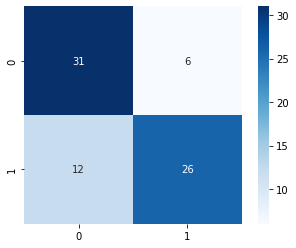

In [5]:
predictions = tree.predict(X_test)
cm = confusion_matrix(y_test, predictions)

sns.heatmap(data = cm,
            annot = True,
            square = True,
            cmap = "Blues")

As we can see the model is prone to predict false negative and false positive.

#### Hyperparameter tuning
We use `GridSearchCV()` to tune our model.  

In [6]:
param_dict = {"criterion": ["gini", "entropy"],
             "max_depth": range(1,10),
             "min_samples_split": range(2, 10),
             "min_samples_leaf": range(2,5)}
tree_gs = GridSearchCV(tree, 
                      param_grid = param_dict,
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1)

tree_gs.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [7]:
tree_gs.score(X_test, y_test), tree_gs.best_params_

(0.7333333333333333,
 {'criterion': 'gini',
  'max_depth': 9,
  'min_samples_leaf': 2,
  'min_samples_split': 9})

<AxesSubplot:>

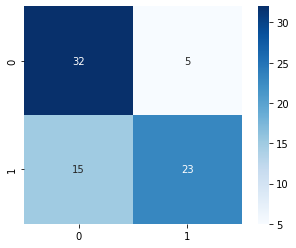

In [8]:
cm_gs = confusion_matrix(y_test, tree_gs.predict(X_test))
sns.heatmap(cm_gs,
           annot = True,
           square = True,
           cmap = "Blues")

Here we have a little improvement in our model but false negative rate is always a little high. 

Maybe our dataset is to small to refine this. Having more samples would be great.

### Logistic Regression


In [9]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train)
X_test_scl = scl.transform(X_test)


In [10]:
lg = LogisticRegression()
lg.fit(X_train_scl, y_train)
lg.score(X_train_scl, y_train), lg.score(X_test_scl, y_test)

(0.8603603603603603, 0.8266666666666667)

In [11]:
param_dict2 = {"C": np.logspace(-4, 4, 50),
              "penalty": ["l2"]}

lg_gs = GridSearchCV(lg,
                    param_grid = param_dict2,
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1,
                    scoring = "f1")

lg_gs.fit(X_train_scl, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-0...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l2']},
             scoring='f1', verbose=1)

In [12]:
lg_gs.score(X_test_scl, y_test)

0.7999999999999999

<AxesSubplot:>

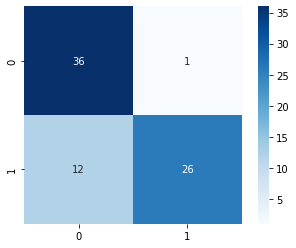

In [13]:
cm_lg_gs = confusion_matrix(y_test, lg_gs.predict(X_test_scl))

sns.heatmap(cm_lg_gs,
           annot = True,
           square = True,
           cmap = "Blues")

### KNeighbors

In [14]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.7567567567567568, 0.6533333333333333)

In [15]:
k_range = list(range(1, 31))
param_dict3 = dict(n_neighbors=k_range)

knn_gs = GridSearchCV(knn,
                     param_grid = param_dict3,
                     cv = 10,
                     verbose = 1,
                     n_jobs = -1)
knn_gs.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [16]:
knn_gs.score(X_test, y_test)

0.68

## Feature Importance

Using our `DecisionTree()` model we now look at the features that more are contributing to the predictions.


In [17]:
tree_opt = DecisionTreeClassifier(criterion = "entropy",
                                 max_depth = 6,
                                 min_samples_leaf = 4,
                                 min_samples_split = 3)

tree_opt.fit(X_train, y_train)
tree_opt.score(X_test, y_test)

0.76

In [18]:
importance = tree_opt.feature_importances_

In [19]:
feature_importance = pd.DataFrame(importance, index = X.columns)
feature_importance.columns = ["Importance"]
    
    

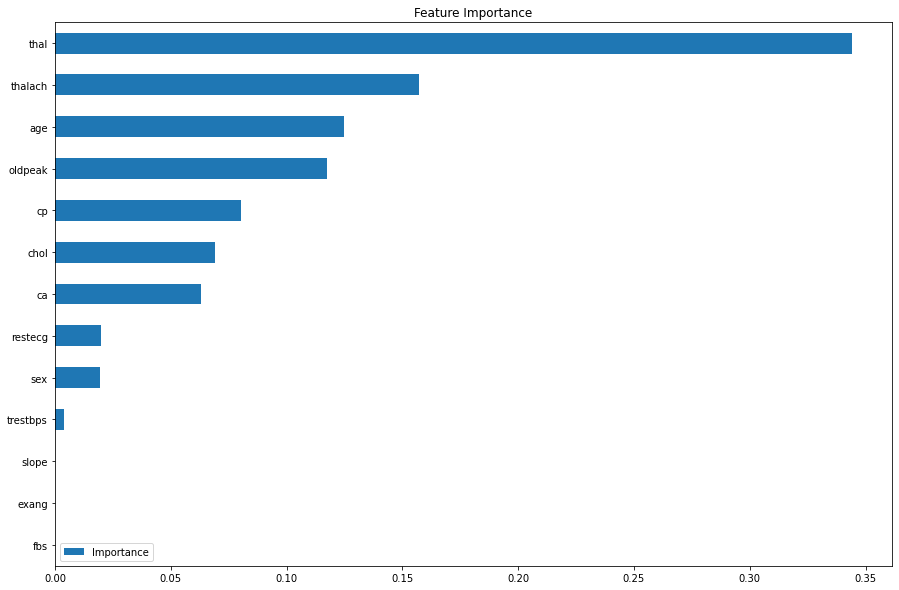

In [20]:
data = feature_importance.sort_values("Importance")
data.plot(kind = "barh", figsize = (15, 10))
plt.title("Feature Importance")
plt.show()